In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity


print("Current path:", os.getcwd())
if os.getcwd().endswith("notebooks"):
    os.chdir("..")
from src.models import naive_dec

plt.style.use('./notebooks/tutorial_style.txt')

Current path: /home/ubuntu/BrainDecoding/notebooks


In [3]:
directories = ["outputs/ET/backbone_20250428", "outputs/ET/backbonesjlayer_20250428", "outputs/ET/backbonesjlayeratt_20250428", "outputs/ET/backbonesjlayeratttrans_resample_20250429"]

desc = ["Backbone", "+ Subject Layer", "+ Attention", "+ Augmentation"]

In [4]:
def plot_accuracy(directories, desc, ax):
  plot_data = []

  for idx, dir in enumerate(directories):
      test_raw = torch.load(os.path.join(dir, "test_outputs.pt"))
      test_outputs, test_labels, test_subjects = test_raw["outputs"], test_raw["labels"], test_raw["subjects"]

      for subject in torch.unique(test_subjects):

          test_mask = test_subjects == subject
          if test_mask.sum() > 0:
              test_acc = accuracy_score(test_labels[test_mask], torch.argmax(test_outputs[test_mask], dim=1))

              plot_data.append({
                  "Run": idx,
                  "Subject": int(subject),
                  "Accuracy": test_acc,
                  "Set": "Test"
              })

  df = pd.DataFrame(plot_data)

  # Plot
  sns.boxplot(x="Run", y="Accuracy", hue="Set", data=df, showfliers=False, ax=ax, palette=["white"])
  sns.swarmplot(x="Run", y="Accuracy", hue="Subject", data=df, palette='tab10', ax=ax, alpha=1, legend=False, marker='o', s=7)

  ax.axhline(y=0.5, color="black", linestyle="--", linewidth=0.7, zorder=10000)


  means = df.groupby(["Run", "Set"])["Accuracy"].mean().reset_index()
  for _, row in means.iterrows():
      x = row["Run"]
      y = row["Accuracy"]
      ax.scatter(x, y, marker="X", color="k", s=20, zorder=1000, label='_none_') 

  ax.set_ylabel("Accuracy")
  ax.set_xlabel("")
  ax.set_xticks(range(len(directories)), desc)
  legend = ax.legend(title=False)
  legend.set_visible(False)
  ax.text(-0.1, 1, r"$\bf{a}$", transform=ax.transAxes)

In [5]:
def plot_attention(experiment_dir, ax):
    loc = np.load("/home/ubuntu/BrainDecoding/configs/layout.npy")
    loc = torch.from_numpy(loc.astype(np.float32))

    config = {
        "channel_dropout": True,
        "p_channel_dropout": 0.4,
        "attention": True,
        "subject_layer": True,
    }

    class DummyBackbone(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.out_features = 1000 
        def forward(self, x):
            return x.mean(dim=-1)  

    model = naive_dec.NaiveModel(
        backbone=DummyBackbone(),
        num_subjects=7,  
        config=config
    )

    state_dict = torch.load(os.path.join(experiment_dir, "best_model.pth"))
    model.load_state_dict(state_dict, strict=False)

    z_re = model.spatial_attention.z_re.detach()
    z_im = model.spatial_attention.z_im.detach()
    cos = model.spatial_attention.cos
    sin = model.spatial_attention.sin

    real = torch.einsum("dkl,klc->dc", z_re, cos)
    imag = torch.einsum("dkl,klc->dc", z_im, sin)
    a = F.softmax(real + imag, dim=-1)

    channel_weights = a.mean(dim=0)  # (C,)
    x = loc[:, 0].cpu().numpy()
    y = loc[:, 1].cpu().numpy()

    positions = np.vstack([x, y]).T

    kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
    kde.fit(positions, sample_weight=channel_weights)

    pixs = 200

    x_grid = np.linspace(np.min(x)-0.1, np.max(x)*1.1, pixs)
    y_grid = np.linspace(np.min(y)-0.1, np.max(y)*1.1, pixs)
    x_grid, y_grid = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    log_dens = kde.score_samples(grid_points)
    densities = np.exp(log_dens).reshape(x_grid.shape)

    #new_cmap = mcolors.ListedColormap(colors)
    ax.imshow(densities, origin='lower', cmap="hot_r")
    sc_x = (x - (np.min(x)-0.1)) / (np.max(x)*1.1 - (np.min(x)-0.1)) * (pixs - 1)
    sc_y = (y - (np.min(y)-0.1)) / (np.max(y)*1.1 - (np.min(y)-0.1)) * (pixs - 1)
    ax.scatter(sc_x, sc_y, c='white', s=20, edgecolors='black', zorder=100)
    ax.axis('off')
    ax.axis('equal')
    ax.text(-0.1, 1, r"$\bf{b}$", transform=ax.transAxes)

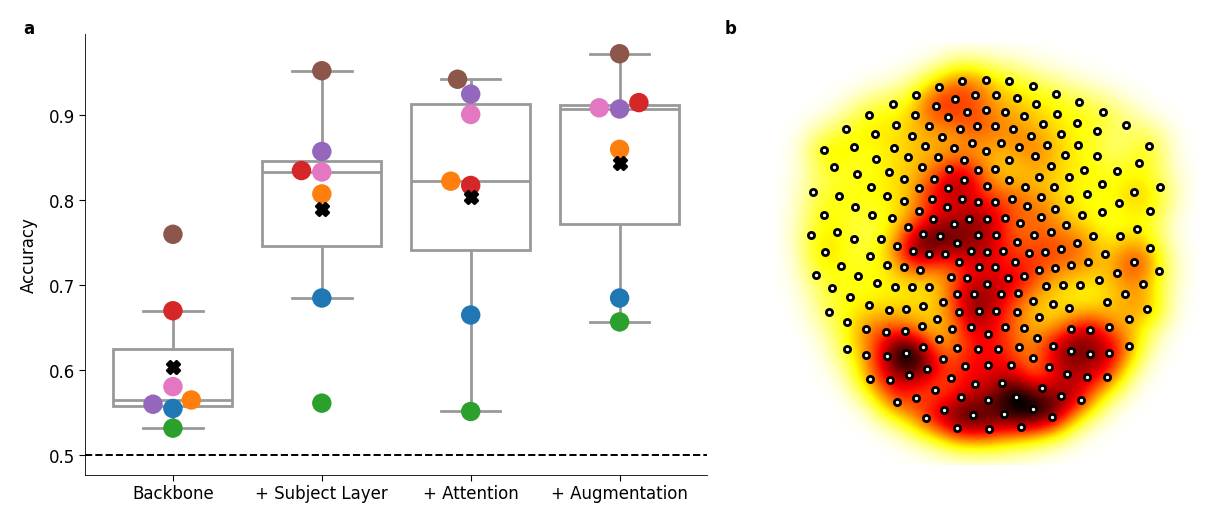

In [6]:
fig = plt.figure(layout='constrained', figsize=(6, 2.5), dpi=200)
ax = fig.subplot_mosaic(
  """
  AB
  """,
  width_ratios=[1, 0.7],
  height_ratios=[1],
)

plot_accuracy(directories, desc, ax["A"])
plot_attention(directories[3], ax["B"])